In [1]:
import pvlib

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import scipy
from scipy.io import loadmat

# Import Experimental Data

The Polydome experiments have been done in the following order, begining and end dates:

| No | Start Date       | End Date         |
|----|------------------|------------------|
| 1  | 01.06.2017 20:00 | 03.06.2017 17:00 |
| 2  | 10.06.2017 16:00 | 12.06.2017 06:00 |
| 3  | 16.06.2017 20:00 | 19.06.2017 06:00 |
| 4  | 19.06.2017 20:00 | 22.06.2017 06:00 |
| 5  | 30.06.2017 20:00 | 03.07.2017 06:00 |
| 6  | 07.07.2017 20:00 | 10.07.2017 06:00 |
| 7  | 13.07.2017 20:00 | 20.07.2017 06:00 |
| 8  | 21.07.2017 20:00 | 24.07.2017 06:00 |

Load the experimental data pertaining to the `seventh` experiment:

In [5]:
exp_id = 'Exp7'

In [6]:
mat_exp1 = loadmat(f'../Data/Luca_experimental_data/{exp_id}.mat')
measured_vals = [*mat_exp1[exp_id].dtype.fields]
measured_vals

['Power',
 'Setpoint',
 'OutsideTemp',
 'SupplyTemp',
 'InsideTemp',
 'LakeTemp',
 'SolRad',
 'SolRad_DA']

## Transform MATLAB struct to a Dataframe

In [7]:
def df_from_mb_struct(mb_mat, field):
    df_field = pd.DataFrame({
            'timestamp': pd.Series(np.array(mb_mat[field][0,0]['time'][0,0]).flatten()),
            'value': pd.Series(np.array(mb_mat[field][0,0]['values'][0,0]).flatten())
            })
    df_field['timestamp'] = pd.to_datetime(df_field['timestamp'], unit = 's', utc = False) + pd.Timedelta(2, 'hours')
    df_field['timestamp'] = pd.DatetimeIndex(df_field['timestamp'], tz = 'Europe/Zurich')
    df_field.set_index('timestamp', inplace = True, drop = True)
    df_field.columns = [field]
    
    return df_field

In [8]:
dict_dfs = {}
for var in measured_vals:
    dict_dfs[var] = df_from_mb_struct(mat_exp1[exp_id], var)

In [9]:
df = dict_dfs[measured_vals[0]]

for idx in range(1, len(measured_vals)):
    df = pd.concat([df, dict_dfs[measured_vals[idx]]], axis = 1)
df

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,LakeTemp,SolRad,SolRad_DA
timestamp,,,,,,,,
2017-07-13 20:00:00+02:00,1688.827586,22.5,24.0,23.9,23.2,22.666667,91.714933,157.0
2017-07-13 20:05:00+02:00,5298.965517,22.5,24.0,15.5,23.5,22.933333,121.538700,111.5
2017-07-13 20:10:00+02:00,6061.344828,22.5,24.0,14.3,23.5,22.733333,101.481617,111.5
2017-07-13 20:15:00+02:00,6062.466667,22.5,24.0,14.0,22.9,22.700000,163.710150,111.5
2017-07-13 20:20:00+02:00,5447.482759,22.5,24.0,14.0,22.6,22.666667,90.039567,111.5
...,...,...,...,...,...,...,...,...
2017-07-20 05:35:00+02:00,1679.517241,22.5,22.0,23.6,23.2,22.333333,3.260000,0.0
2017-07-20 05:40:00+02:00,1675.666667,22.5,22.0,23.6,23.2,22.266667,3.250000,0.0
2017-07-20 05:45:00+02:00,1679.137931,22.5,22.0,23.6,23.2,22.300000,3.240000,0.0


## Fix some experimental values

### Adjust power from kW to W and remove fan baseline

In [10]:
df['Power'] = df['Power'] - 1.67 * 1000 # remove the fan power consumption
df['Power'] = np.where(df['Power'] > 6300, 6300, df['Power']) # cap to 1 compressor to remove non-linear effects

### Average the Inside Temperature

Take the inside temperature to be the average of the two sensors (`InsideTemp` and `LakeTemp`):

In [11]:
df['InsideTemp'] = df[['LakeTemp', 'InsideTemp']].mean(axis = 1) # Averaged Inside Temperature

In [12]:
df.drop(columns = ['LakeTemp', 'SolRad_DA'], inplace = True) # Drop GHI prediction and the non-averaged inside temp measure
df

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad
timestamp,,,,,,
2017-07-13 20:00:00+02:00,18.827586,22.5,24.0,23.9,22.933333,91.714933
2017-07-13 20:05:00+02:00,3628.965517,22.5,24.0,15.5,23.216667,121.538700
2017-07-13 20:10:00+02:00,4391.344828,22.5,24.0,14.3,23.116667,101.481617
2017-07-13 20:15:00+02:00,4392.466667,22.5,24.0,14.0,22.800000,163.710150
2017-07-13 20:20:00+02:00,3777.482759,22.5,24.0,14.0,22.633333,90.039567
...,...,...,...,...,...,...
2017-07-20 05:35:00+02:00,9.517241,22.5,22.0,23.6,22.766667,3.260000
2017-07-20 05:40:00+02:00,5.666667,22.5,22.0,23.6,22.733333,3.250000
2017-07-20 05:45:00+02:00,9.137931,22.5,22.0,23.6,22.750000,3.240000


## Compute the Solar angles

Get altitude information for Polydome GPS coordinates:

<img src="Images/polydome_altitude.png" alt="Polydome Altitude Source" width="500"/>

In [13]:
latitude = 46.521476
longitude = 6.569009
altitude = 395

Compute the solar position from GPS/altitude data:

<img src="Images/solar_angles.png" alt="Diagram of the zenith/azimuth angles definition" width="500"/>

In [14]:
df_solarposition = pvlib.solarposition.get_solarposition(
    time = df.index,
    latitude = latitude, 
    longitude = longitude,
    temperature = df['OutsideTemp'],
    altitude = altitude
)
df_solarposition

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
timestamp,,,,,,
2017-07-13 20:00:00+02:00,77.726968,77.795211,12.273032,12.204789,288.783339,-5.802162
2017-07-13 20:05:00+02:00,78.534908,78.607746,11.465092,11.392254,289.630841,-5.802550
2017-07-13 20:10:00+02:00,79.337991,79.416004,10.662009,10.583996,290.480180,-5.802939
2017-07-13 20:15:00+02:00,80.135916,80.219798,9.864084,9.780202,291.331669,-5.803327
2017-07-13 20:20:00+02:00,80.928349,81.018937,9.071651,8.981063,292.185610,-5.803715
...,...,...,...,...,...,...
2017-07-20 05:35:00+02:00,94.508501,94.508501,-4.508501,-4.508501,53.359623,-6.350089
2017-07-20 05:40:00+02:00,93.814709,93.814709,-3.814709,-3.814709,54.303944,-6.350290
2017-07-20 05:45:00+02:00,93.112672,93.112672,-3.112672,-3.112672,55.241364,-6.350492


Check the difference between the real/geometrical zenith and the apparent zenith:

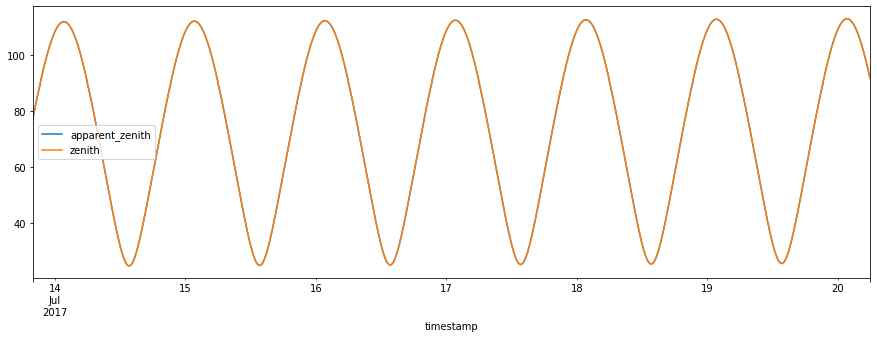

In [15]:
df_solarposition[['apparent_zenith', 'zenith']].plot(figsize = (15, 5))
plt.show()

Compute the angle of incidence of the sun on the surface: 

<img src="Images/angle_of_incidence.jpg" alt="Angle of incidence" width="500"/>

In [16]:
surface_tilt = 0
surface_azimuth = 0

In [17]:
df_aoi = pvlib.irradiance.aoi(
    surface_tilt = surface_tilt,
    surface_azimuth = surface_azimuth,
    solar_zenith = df_solarposition['apparent_zenith'],
    solar_azimuth = df_solarposition['azimuth']
)
df_aoi

timestamp
2017-07-13 20:00:00+02:00    77.726968
2017-07-13 20:05:00+02:00    78.534908
2017-07-13 20:10:00+02:00    79.337991
2017-07-13 20:15:00+02:00    80.135916
2017-07-13 20:20:00+02:00    80.928349
                               ...    
2017-07-20 05:35:00+02:00    94.508501
2017-07-20 05:40:00+02:00    93.814709
2017-07-20 05:45:00+02:00    93.112672
2017-07-20 05:50:00+02:00    92.402637
2017-07-20 05:55:00+02:00    91.684848
Name: aoi, Length: 1848, dtype: float64

## Compute the Solar radiation components

In [18]:
df_erbs = pvlib.irradiance.erbs(
    ghi = df['SolRad'],
    zenith = df_solarposition['zenith'],
    datetime_or_doy = df.index
)
df_erbs.head()

,dni,dhi,kt
timestamp,,,
2017-07-13 20:00:00+02:00,32.174594,84.913015,0.328436
2017-07-13 20:05:00+02:00,167.597825,88.433972,0.465824
2017-07-13 20:10:00+02:00,104.009389,82.377507,0.418275
2017-07-13 20:15:00+02:00,767.555215,33.326318,0.729609
2017-07-13 20:20:00+02:00,126.334677,70.317711,0.436653


In [19]:
erbs_ghi = df_erbs['dhi'] + df_erbs['dni']*np.cos(np.radians(df_solarposition['zenith']))

Compare `erbs_ghi` with measured ghi to confirm they are the same:

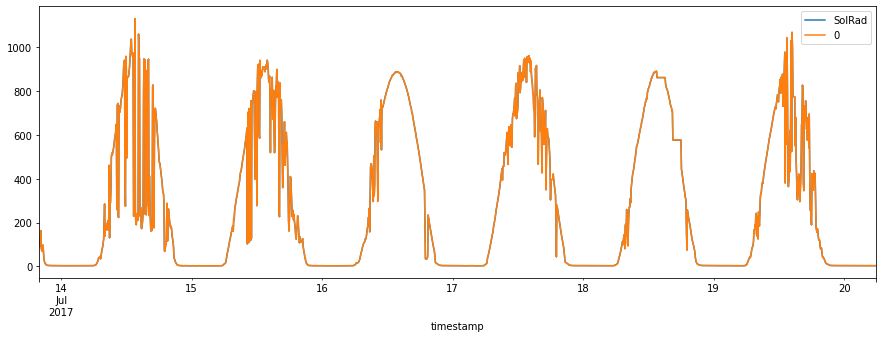

In [20]:
pd.concat([df['SolRad'], erbs_ghi], axis = 1).plot(figsize = (15, 5))
plt.show()

Compute the in-plane irradiance components:

In [21]:
#poa_sky_diffuse
df_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
    surface_tilt = surface_tilt,
    surface_azimuth = surface_azimuth,
    solar_zenith = df_solarposition['apparent_zenith'],
    solar_azimuth = df_solarposition['azimuth'],
    dni = df_erbs['dni'],
    ghi = df['SolRad'],
    dhi = df_erbs['dhi'],
)
df_sky_diffuse

timestamp
2017-07-13 20:00:00+02:00    84.913015
2017-07-13 20:05:00+02:00    88.433972
2017-07-13 20:10:00+02:00    82.377507
2017-07-13 20:15:00+02:00    33.326318
2017-07-13 20:20:00+02:00    70.317711
                               ...    
2017-07-20 05:35:00+02:00     3.260000
2017-07-20 05:40:00+02:00     3.250000
2017-07-20 05:45:00+02:00     3.240000
2017-07-20 05:50:00+02:00     3.340000
2017-07-20 05:55:00+02:00     3.380000
Name: dhi, Length: 1848, dtype: float64

In [22]:
#poa_ground_diffuse
df_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
    surface_tilt = surface_tilt,
    ghi = df['SolRad'],
    surface_type = 'urban' # used for gound_diffuse calculation
)
df_ground_diffuse

timestamp
2017-07-13 20:00:00+02:00    0.0
2017-07-13 20:05:00+02:00    0.0
2017-07-13 20:10:00+02:00    0.0
2017-07-13 20:15:00+02:00    0.0
2017-07-13 20:20:00+02:00    0.0
                            ... 
2017-07-20 05:35:00+02:00    0.0
2017-07-20 05:40:00+02:00    0.0
2017-07-20 05:45:00+02:00    0.0
2017-07-20 05:50:00+02:00    0.0
2017-07-20 05:55:00+02:00    0.0
Name: diffuse_ground, Length: 1848, dtype: float64

In [23]:
df_poa_components = pvlib.irradiance.poa_components(
    aoi = df_aoi,
    dni = df_erbs['dni'],
    poa_sky_diffuse = df_sky_diffuse,
    poa_ground_diffuse = df_ground_diffuse
)
df_poa_components

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
timestamp,,,,,
2017-07-13 20:00:00+02:00,91.752384,6.839369,84.913015,84.913015,0.0
2017-07-13 20:05:00+02:00,121.747537,33.313565,88.433972,88.433972,0.0
2017-07-13 20:10:00+02:00,101.620807,19.243300,82.377507,82.377507,0.0
2017-07-13 20:15:00+02:00,164.817387,131.491069,33.326318,33.326318,0.0
2017-07-13 20:20:00+02:00,90.236835,19.919124,70.317711,70.317711,0.0
...,...,...,...,...,...
2017-07-20 05:35:00+02:00,3.260000,-0.000000,3.260000,3.260000,0.0
2017-07-20 05:40:00+02:00,3.250000,-0.000000,3.250000,3.250000,0.0
2017-07-20 05:45:00+02:00,3.240000,-0.000000,3.240000,3.240000,0.0


In [24]:
df['SolRad']

timestamp
2017-07-13 20:00:00+02:00     91.714933
2017-07-13 20:05:00+02:00    121.538700
2017-07-13 20:10:00+02:00    101.481617
2017-07-13 20:15:00+02:00    163.710150
2017-07-13 20:20:00+02:00     90.039567
                                ...    
2017-07-20 05:35:00+02:00      3.260000
2017-07-20 05:40:00+02:00      3.250000
2017-07-20 05:45:00+02:00      3.240000
2017-07-20 05:50:00+02:00      3.340000
2017-07-20 05:55:00+02:00      3.380000
Name: SolRad, Length: 1848, dtype: float64

In [25]:
print(df_sky_diffuse.equals(df_poa_components['poa_sky_diffuse']))
print(df_ground_diffuse.equals(df_poa_components['poa_ground_diffuse']))

True
True


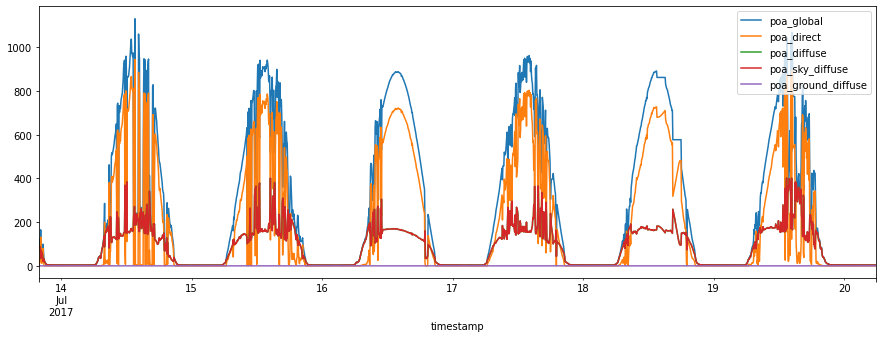

In [26]:
df_poa_components.plot(figsize = (15, 5))
plt.show()

# Compile the WDB vector

In [27]:
df_wdb = df.copy()
df_wdb['time'] = (df_wdb.index - df_wdb.index[0]).total_seconds()

Add the solar angles:

In [28]:
df_wdb['zenith'] = df_solarposition['apparent_zenith'] # apparent_zenith takes into account refraction due to atmosphere
df_wdb['azimuth'] = df_solarposition['azimuth']
df_wdb['aoi'] = df_aoi

Add the estimated radiation values:

In [29]:
df_wdb['dni'] = df_erbs['dni']
df_wdb['dhi'] = df_erbs['dhi']

In [30]:
df_wdb['poa_direct'] = df_poa_components['poa_direct']
df_wdb['poa_diffuse'] = df_poa_components['poa_diffuse']

In [31]:
# Radiative temperature of the sky
df_wdb['Tsky_rad'] = df_wdb['OutsideTemp'] - 6 # from email with Manuel

df_wdb['relative_humidity'] = 50 # relative humidity. placeholder
df_wdb['precipitation'] = -9999 # placeholder
df_wdb['cloud_index'] = 0.5 # from email with Manuel, for the moment assumed to not be used by the model
df_wdb['pressure'] = 96300 # placeholder, taken as mean of PUY station over the last year

df_wdb['wind_speed'] = 0 # placeholder value
df_wdb['wind_direction'] = -9999 # placeholder value

df_wdb['incidence_main'] = -9999 # also missing in sample dataset
df_wdb['incidence_second'] = -9999 # also missing in sample dataset

Change the timestamp from being an index, to being a regular column:

In [32]:
df_wdb.reset_index(inplace = True)

Transform it to the YYYYmmddHHMM format expected by Carnot WDB:

In [33]:
df_wdb['timestamp'] = df_wdb['timestamp'].dt.strftime("%Y%m%d%H%M").astype('int')

In [34]:
df_wdb['time'] = df_wdb['time'].astype('int')

In [35]:
df_wdb = df_wdb[['time', 'timestamp', 'zenith', 'azimuth', 'dni', 'dhi', 'OutsideTemp', 'Tsky_rad', 'relative_humidity', 'precipitation', 'cloud_index', 'pressure', 'wind_speed', 'wind_direction', 'aoi', 'incidence_main', 'incidence_second', 'poa_direct', 'poa_diffuse']]

## Export the WDB dataframe to pickle

In [36]:
df_wdb.to_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")

In [37]:
df.to_pickle(f"../Data/Experimental_python/{exp_id}_data.pkl")

## Export the WDB matrix to MATLAB

In [38]:
scipy.io.savemat(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", {'Exp_WDB': df_wdb.to_numpy()})

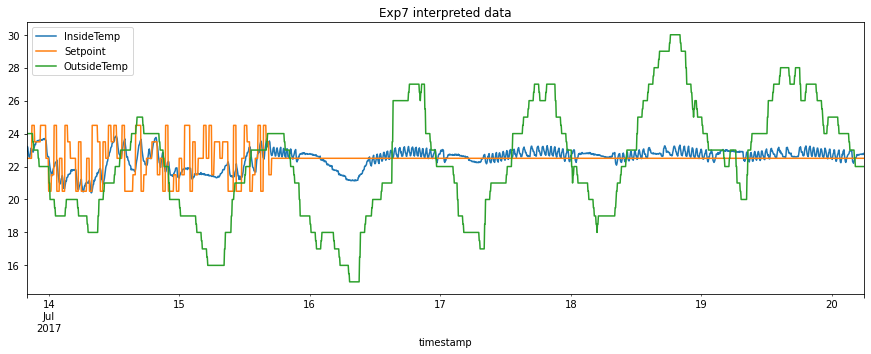

In [39]:
df[['InsideTemp', 'Setpoint', 'OutsideTemp']].plot(figsize = (15, 5))
plt.title(f"{exp_id} interpreted data")
plt.show()